In [1]:
!nvidia-smi

Tue Oct 10 21:22:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:D8:00.0  On |                  N/A |
|  0%   46C    P8    34W / 370W |    751MiB / 10240MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import callbacks, optimizers, losses
from keras import backend as K
from sklearn.model_selection import train_test_split
import seaborn as sns
import string
import pandas as pd
# from rich import print
import pathlib
from scipy import io as sio

from hvsrUNet.module.GPRNet import GPRNet
from hvsrUNet.toolbox.smooth import smooth

%matplotlib inline

In [3]:
path_dir = pathlib.Path('../data/')
hvsrs = sio.loadmat(path_dir/'hvsrs.mat')['hvsrs']
disps = sio.loadmat(path_dir/'disps.mat')['disps']
Vss = sio.loadmat(path_dir/'models.mat')['models']
fks = sio.loadmat(path_dir/'freq.mat')['freq']
fks = fks.reshape(-1)
hzcum = sio.loadmat(path_dir/'hzcum.mat')['hzcum']
hzcum = hzcum.reshape(-1)

In [3]:
hvsrs.shape, disps.shape, Vss.shape, fks.shape, hzcum.shape

((216, 512), (216, 512), (216, 512), (512,), (512,))

In [4]:
disps    = np.expand_dims(disps, axis=-1) / 1000.
Vss      = np.expand_dims(Vss, axis=-1) / 1000.

X_train, X_test, y_train, y_test = train_test_split(disps, Vss, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = tf.expand_dims(X_train, axis=2)
y_train = tf.expand_dims(y_train, axis=2)
X_valid = tf.expand_dims(X_valid, axis=2)
y_valid = tf.expand_dims(y_valid, axis=2)
X_test = tf.expand_dims(X_test, axis=2)
y_test = tf.expand_dims(y_test, axis=2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape

(TensorShape([137, 512, 1, 1]),
 TensorShape([137, 512, 1, 1]),
 TensorShape([44, 512, 1, 1]),
 TensorShape([44, 512, 1, 1]),
 TensorShape([35, 512, 1, 1]),
 TensorShape([35, 512, 1, 1]))

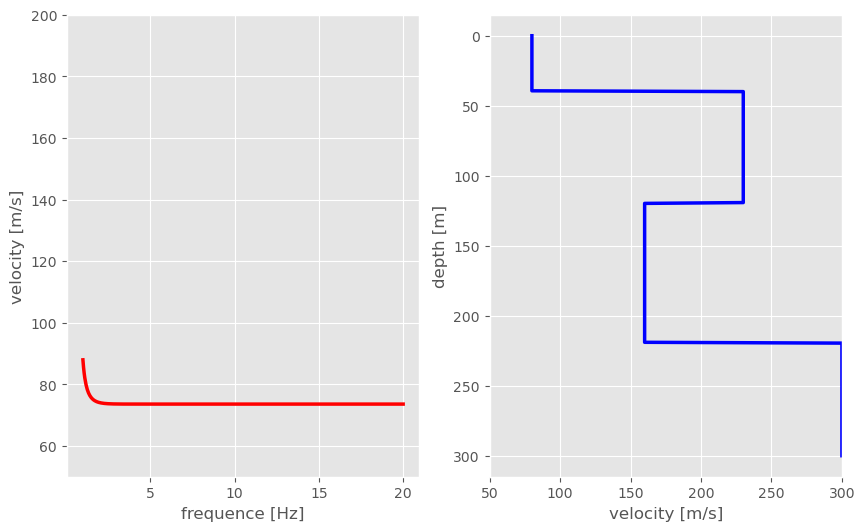

In [5]:
%matplotlib inline
i = np.random.randint(0, X_train.shape[0])

disp      = disps[i] * 1000
vs1      = Vss[i] * 1000

with plt.style.context(['ggplot']):
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(121)
    ax1.plot(fks, disp, color='red', label='True', linewidth=2.5)
    ax1.set_ylim([50, 200])
    ax1.set_xlabel('frequence [Hz]')
    ax1.set_ylabel('velocity [m/s]')
    ax1.grid(True)
    ax2 = fig.add_subplot(122)
    ax2.plot(vs1, hzcum, color='blue', label='True', linewidth=2.5)
    ax2.set_xlim([50, 300])
    # ax.set_ylim([0, 100])
    ax2.invert_yaxis()
    ax2.set_xlabel('velocity [m/s]')
    ax2.set_ylabel('depth [m]')
    ax2.grid(True)
    

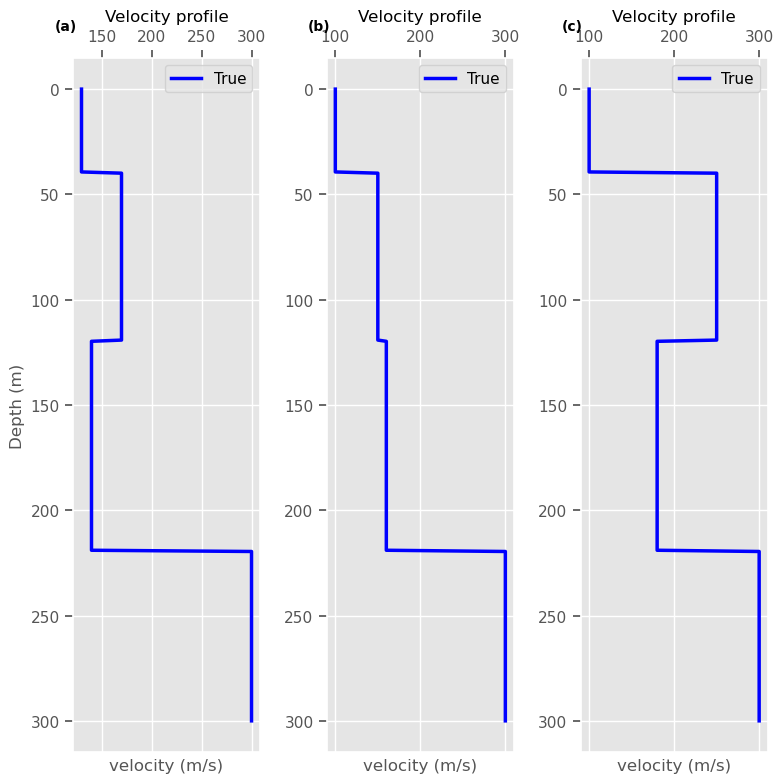

In [6]:
np.random.seed(33)
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    
    for j, ax in enumerate(axes.flat):
        i = np.random.randint(0, 50)

        ax.plot(np.squeeze(y_test[i, ...])*1000, hzcum, color='blue', label='True', linewidth=2.5)
        ax.set_title('Velocity profile')
        ax.set_xlabel('velocity (m/s)')
        ax.legend()
        ax.text(-0.1, 1.04, '('+string.ascii_lowercase[j]+')', transform=ax.transAxes, size=10, weight='bold')
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    axes[0].set_ylabel('Depth (m)')
    fig.tight_layout()
    plt.show()

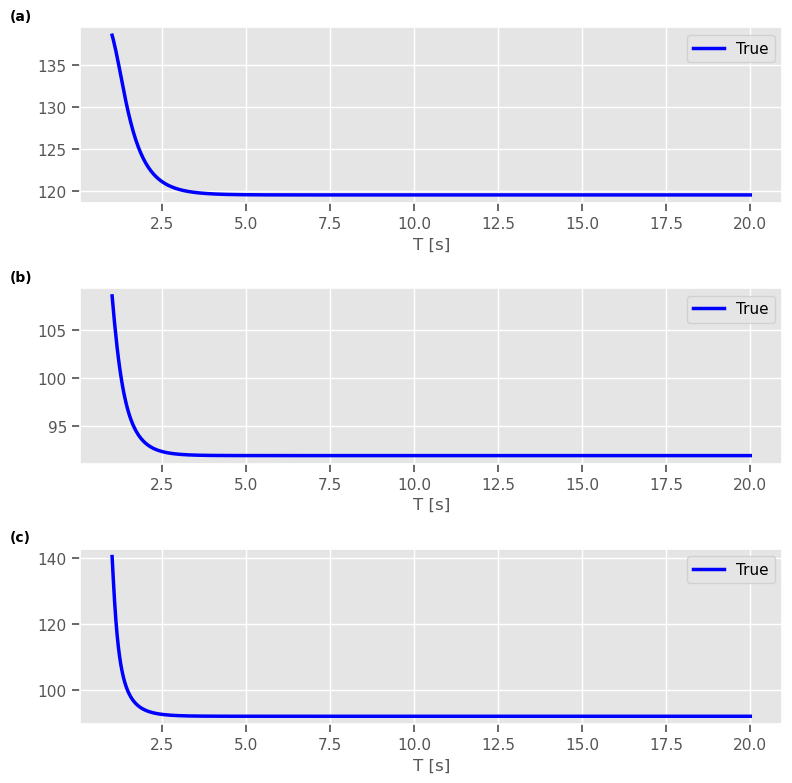

In [7]:
np.random.seed(33)
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(3, 1, figsize=(8, 8))
    
    for j, ax in enumerate(axes.flat):
        i = np.random.randint(0, 50)

        ax.plot(fks, np.squeeze(X_test[i, ...])*1000, color='blue', label='True', linewidth=2.5)

        ax.set_xlabel('T [s]')
        ax.legend()
        ax.text(-0.1, 1.04, '('+string.ascii_lowercase[j]+')', transform=ax.transAxes, size=10, weight='bold')

    fig.tight_layout()
    plt.show()

In [6]:
model = GPRNet(im_width=1, im_height=512, neurons=8, kern_sz=20,enable_dropout=False)
# model.summary()

In [7]:
name_checkpoint = 'checkpoints/disp_2023_10_10/Weights/{epoch:04d}.keras' # 保存模型的路径。
log_dir = 'checkpoints/disp_2023_10_10/Logs' # 日志文件保存的目录。
name_csv = 'checkpoints/disp_2023_10_10/Logs/disp.csv' # 将被写入的文件的路径，例如：csv_logger(filename='training.log')。
lr_val = 0.0001
batch_size = 32
epochs = 1000
n_batches = len(X_train) / batch_size
n_batches = int(np.ceil(n_batches))

def R2_score(v_true, v_pred):
    ssres = K.sum(K.square(v_true - v_pred))
    sstot = K.sum(K.square(v_true - K.mean(v_true)))
    return 1 - ssres / sstot

model_checkpoint = callbacks.ModelCheckpoint(name_checkpoint, # 保存模型的路径。
                                #monitor='val_loss',         # 监控的数据。
                                monitor='val_R2_score',
                                verbose=0,                  # 日志显示模式，0或1。
                                save_best_only=False,       # True，那么最近验证误差最低的模型就不会被覆盖。
                                save_weights_only=False,    # True，那么只有模型的权重会被保存。
                                #mode='auto',                # {auto, min, max}的其中之一。
                                mode='max',
                                save_freq=10*n_batches)               # 'epoch'或整数。保存频率。

early_stopping = callbacks.EarlyStopping(monitor='val_loss', # 监控的数据。
                                min_delta=0,                    # 增大或减小的阈值，只有大于这个部分才算作improvement。
                                patience=100,                     # 没有进步的训练轮数，在这之后训练就会被停止。
                                verbose=0,                      # 日志显示模式，0或1。
                                mode='auto',                    # {auto, min, max}的其中之一。
                                baseline=None,                  # 要监控的数量的基准值，如果模型没有显示出基准的改善，则训练将停止。
                                restore_best_weights=False)     # 是否从具有监视器数量的最佳值的时期恢复模型权重。如果为False，则使用在训练的最后一步获得的模型权重。

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', # 监控的数据。
                                factor=0.5,                     # 触发时将学习率乘以系数的因数。
                                patience=15,                    # 没有进步的训练轮数，在这之后训练速率会被降低。
                                verbose=0,                      # 整数。0：安静，1：更新信息。
                                mode='auto',                    # {auto, min, max}的其中之一。
                                min_delta=0.000001,               # 对于测量新阈值的阈值，只关注巨大的变化。
                                cooldown=0,                     # 在lr被降低之后，训练将在cooldown内的epoch之后继续。
                                min_lr=0)                       # 学习率的下边界。

csv_logger = callbacks.CSVLogger(name_csv, # 将被写入的文件的路径，例如：csv_logger(filename='training.log')。
                                separator=',',              # 用于隔开值的字符串。
                                append=False)               # 如果为True，则将数据添加到现有文件中，而不会重新启动。

optimizer = optimizers.Adam(learning_rate=lr_val)
loss = losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=['mae', 'mse', R2_score])

history = model.fit(X_train, y_train,
          validation_data=[X_valid,y_valid],
                  epochs=epochs,
                   batch_size=batch_size,
                   callbacks=[model_checkpoint, early_stopping, reduce_lr, csv_logger],
                   verbose=1)

Epoch 1/1000
5/5 [==============================] - 10s 320ms/step - loss: 0.0486 - mae: 0.2099 - mse: 0.0486 - R2_score: -9.6139 - val_loss: 0.0450 - val_mae: 0.2012 - val_mse: 0.0450 - val_R2_score: -8.8395 - lr: 1.0000e-04
Epoch 2/1000
5/5 [==============================] - 0s 48ms/step - loss: 0.0427 - mae: 0.1954 - mse: 0.0427 - R2_score: -8.1185 - val_loss: 0.0344 - val_mae: 0.1728 - val_mse: 0.0344 - val_R2_score: -6.5466 - lr: 1.0000e-04
Epoch 3/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.0283 - mae: 0.1522 - mse: 0.0283 - R2_score: -4.8940 - val_loss: 0.0129 - val_mae: 0.0867 - val_mse: 0.0129 - val_R2_score: -1.8330 - lr: 1.0000e-04
Epoch 4/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.0102 - mae: 0.0804 - mse: 0.0102 - R2_score: -1.4257 - val_loss: 0.0134 - val_mae: 0.1010 - val_mse: 0.0134 - val_R2_score: -1.7560 - lr: 1.0000e-04
Epoch 5/1000
5/5 [==============================] - 0s 41ms/step - loss: 0.0093 - mae: 0.0814 - mse: 0

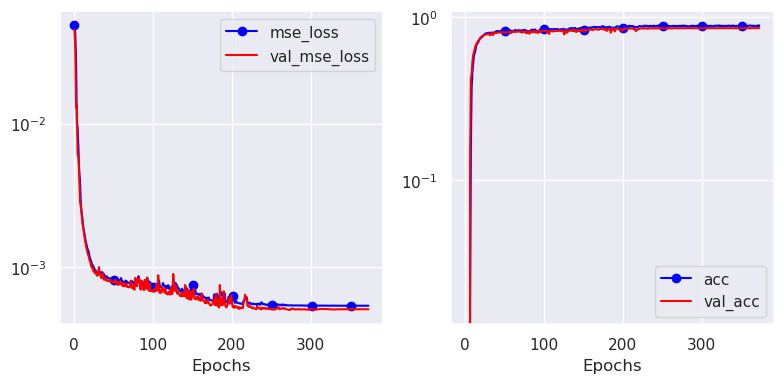

In [8]:
training_log = pd.read_csv('checkpoints/disp_2023_10_10/Logs/disp.csv')
training_log.head()

mse_loss = training_log['loss']
val_mse_loss = training_log['val_loss']
acc = training_log['R2_score']
val_acc = training_log['val_R2_score']

accu = {'mse_loss': mse_loss, 
        'val_mse_loss': val_mse_loss,
        'acc': acc,
        'val_acc': val_acc}

value = [mse_loss, val_mse_loss, acc, val_acc]
name = ['mse_loss', 'val_mse_loss', 'acc', 'val_acc']

epochs = range(1, len(acc) + 1)

with plt.style.context('ggplot'):
    sns.set_theme(style='darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    for i, ax in enumerate(axes):

        ax.plot(epochs, value[2*i], label=name[2*i], marker='o', color='blue', markevery=50)
        ax.plot(epochs, value[2*i+1], label=name[2*i+1], color='red')
        ax.set_yscale('log')
        ax.set_xlabel('Epochs')
        ax.legend()
        #ax.set_title(name)
    
    plt.tight_layout()

plt.show()
    

In [ ]:
model.load_weights('checkpoints/2023_10_08/Weights/0430.keras')

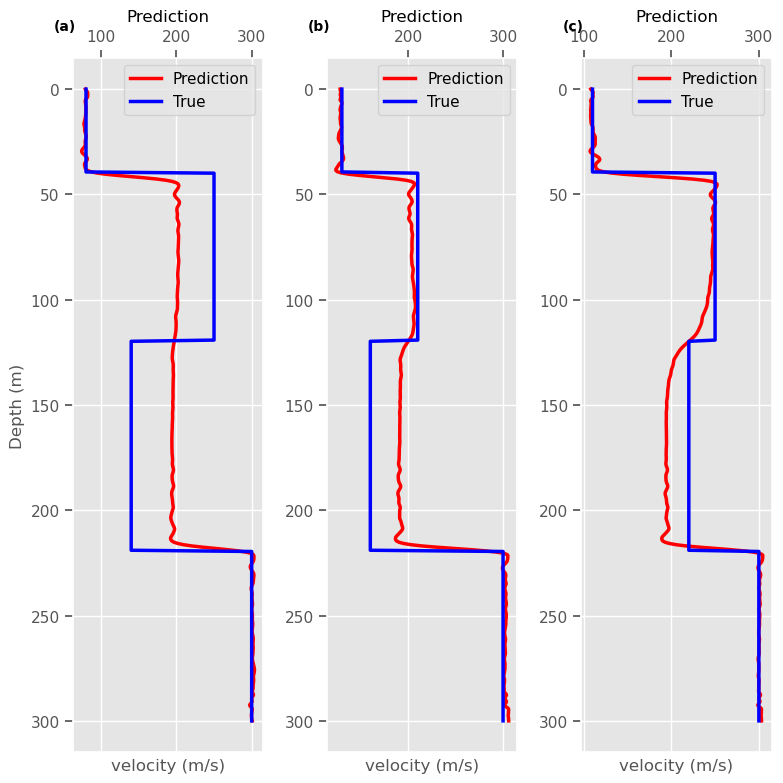

In [10]:
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    
    for j, ax in enumerate(axes.flat):
        i = np.random.randint(0, 30)
        ypred = model.predict(X_test[i:i+1, ...])
        yy = smooth(np.squeeze(ypred), window_len=10, window='blackman')
        depth = np.linspace(hzcum.min(), hzcum.max(), len(yy))

        ax.plot(yy*1000, depth, color='red', label='Prediction', linewidth=2.5)
        ax.plot(np.squeeze(y_test[i, ...])*1000, hzcum, color='blue', label='True', linewidth=2.5)
        ax.set_title('Prediction')
        ax.set_xlabel('velocity (m/s)')
        ax.legend()
        ax.text(-0.1, 1.04, '('+string.ascii_lowercase[j]+')', transform=ax.transAxes, size=10, weight='bold')
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    axes[0].set_ylabel('Depth (m)')
    fig.tight_layout()
    plt.show()

In [ ]:
yy_im = []
y_im = []

for j in range(100):
    # i = np.random.randint(0, 240)
    if j < 20:
        i = 20
    elif j < 40:
        i = 21
    elif j < 60:
        i = 22
    elif j < 80:
        i = 23
    else:
        i = 24
    ypred = model.predict(X_test[i:i+1, ...])
    yy = smooth(np.squeeze(ypred), window_len=18, window='blackman')
    depth = np.linspace(hzcum.min(), hzcum.max(), len(yy))
    yy_im.append(yy*1000)
    y_im.append(np.squeeze(y_test[i, ...])*1000)

yy_im = np.array(yy_im)
y_im = np.array(y_im)
print(yy_im.shape, y_im.shape)


In [ ]:
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    im0 = axes[0].imshow(y_im.T, cmap='RdYlBu', aspect='auto', extent=[0, 100, hzcum.max(), 0])
    axes[0].set_xlabel('Number of samples')
    axes[0].set_ylabel('Depth (m)')
    axes[0].set_title('True')
    axes[0].set_ylim([75, 0])
    axes[0].grid(False)
    plt.colorbar(im0, ax=axes[0])
    im1 = axes[1].imshow(yy_im.T, cmap='RdYlBu', aspect='auto', extent=[0, 100, hzcum.max(), 0])
    axes[1].set_xlabel('Number of samples')
    axes[1].set_ylabel('Depth (m)')
    axes[1].set_title('Prediction')
    axes[1].set_ylim([75, 0])
    axes[1].grid(False)
    plt.colorbar(im1, ax=axes[1])
    plt.tight_layout()

In [ ]:
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    im0 = axes[0].imshow(y_im.T, cmap='RdYlBu', aspect='auto', extent=[0, 100, hzcum.max(), 0])
    axes[0].set_xlabel('Number of samples')
    axes[0].set_ylabel('Depth (m)')
    axes[0].set_title('True')
    axes[0].set_ylim([75, 0])
    axes[0].grid(False)
    plt.colorbar(im0, ax=axes[0])
    im1 = axes[1].imshow(yy_im.T, cmap='RdYlBu', aspect='auto', extent=[0, 100, hzcum.max(), 0])
    axes[1].set_xlabel('Number of samples')
    axes[1].set_ylabel('Depth (m)')
    axes[1].set_title('Prediction')
    axes[1].set_ylim([75, 0])
    axes[1].grid(False)
    plt.colorbar(im1, ax=axes[1])
    plt.tight_layout()